In [6]:
import os
import argparse
import math
import time
import ast
from copy import copy
from glob import glob

import pandas as pd
import numpy as np

import pyproj
from pyproj import Proj
import cv2
from shapely.ops import transform
import rioxarray
import geopandas as gpd

import ultralytics
from ultralytics import YOLO
#ultralytics.checks()

import concurrent
import concurrent.futures
from concurrent.futures.thread import ThreadPoolExecutor


In [7]:


from shapely.geometry import Point
def chunk_df(img_paths, num_chunks=10):
    # Calculate the number of rows per chunk
    rows_per_chunk = len(img_paths) // num_chunks
    df_chunks = [np.array(img_paths[i : i + rows_per_chunk]) for i in range(0, len(img_paths), rows_per_chunk)]
    return df_chunks


def tile_dimensions_and_utm_coords(tile_path): #used
    """ Obtain tile band, height and width and utm coordinates
    Args: tile_path(str): the path of the tile 
    Returns: 
    utmx(np array): the x utm coordinates corresponding with the tile coordinate convention (origin in upper left hand corner)
    utmy(np array): the y utm coordinates corresponding with the tile coordinate convention (origin in upper left hand corner)
    tile_band(int): the number of bands
    tile_height(int): the height of the tile (in pixels)
    tile_width(int): the width of the tile (in pixels)
    """
    ## Get tile locations
    da = rioxarray.open_rasterio(tile_path) ## Read the data
    # Compute the lon/lat coordinates with rasterio.warp.transform
    # lons, lats = np.meshgrid(da['x'], da['y'])
    tile_band, tile_height, tile_width = da.shape[0], da.shape[1], da.shape[2]
    utmx = np.array(da['x'])
    utmy = np.array(da['y'])
    crs =  rioxarray.open_rasterio(tile_path).rio.crs
    return(utmx, utmy, crs, tile_band, tile_height, tile_width)
    del da


def process_results(results, tile_height, tile_width, item_dim):
    #xyxys = []
    bbox_pixel_coords_list = [] #xyxy coords with repsect to the tile
    conf_list = [] #probability
    class_name_list = [] #class name
    image_names_list = []
    lat_lons = []
    for result in results:
        boxes = result.boxes
        image_name = os.path.splitext(os.path.basename(result.path))[0]
        if len(boxes) > 0: 
            #get valeus for all bounding boxes
            #class name
            class_name_list.extend([result.names[class_number] for class_number in boxes.cls.cpu().detach().tolist()])
            
            conf_list.extend(boxes.conf.cpu().detach().tolist())

            xyxy = boxes.xyxy.cpu().detach().numpy() - 1 #read xmin,ymin,xmax,ymax coordinates to memory as a numpy array
            xyxy = np.round(xyxy).astype(np.int32).tolist()  # round so that it can be used for utm to lonlat conversion, check if zero indexed
            
            image_names_list.extend([image_name]*len(xyxy)) # The index is a six-digit number like '000023'.
            #calculate the tile level pixel coordinates
            bbox_pixel_coords_list.extend([calculate_tile_level_bbox(image_name, box, item_dim,
                                                                     tile_width, tile_height) for box in xyxy])
        del boxes
    return pd.DataFrame({"confidence":conf_list, "class_name": class_name_list,
                       "image_names": image_names_list, "bbox_pixel_coords": bbox_pixel_coords_list})#,  dtype=dtypes


def predict_process(img_paths, tile_height, tile_width, model, args):
    # obtain predictions over the dataframe
    results_df = pd.DataFrame({})
    num_chunks = len(img_paths)//50
    for df_chunk in chunk_df(img_paths, num_chunks=num_chunks):
        results = model.predict(df_chunk.tolist(), save=False, imgsz=args.imgsz)#, conf=0.5)
        #process_results(results, utmx, utmy, utm_proj, tile_height, tile_width, item_dim=args.imgsz)
        results_df = pd.concat([results_df, process_results(results, tile_height, tile_width, item_dim=args.imgsz)])
        del results, df_chunk
    return results_df


def calculate_tile_level_bbox(image_name, xyxy, item_dim, tile_width, tile_height):
    obj_xmin, obj_ymin, obj_xmax, obj_ymax = xyxy
    #identify rows and columns
    y, x = image_name.split("_")[-2:] #name of tif with the extension removed; y=row;x=col
    # Each chip xml goes from 1 - item_dim, specify the "0", or the end point of the last xml
    image_minx = int(x)*item_dim 
    image_miny = int(y)*item_dim

    #add the bounding boxes
    obj_xmin = image_minx + obj_xmin
    obj_ymin = image_miny + obj_ymin
    obj_xmax = image_minx + obj_xmax
    obj_ymax = image_miny + obj_ymax
    # correct bboxes that extend past the bounds of the tile width/height
    if int(obj_xmin) >= tile_width:
        obj_xmin = tile_width - 1
    if int(obj_xmax) >= tile_width:
        obj_xmax = tile_width - 1
    if int(obj_ymin) >= tile_height:
        obj_ymin = tile_height - 1
    if int(obj_ymax) >= tile_height:
        obj_ymax = tile_height - 1
    
    return [obj_xmin, obj_ymin, obj_xmax, obj_ymax]


def transform_point_utm_to_wgs84(utm_proj, utm_xcoord, utm_ycoord): #used
    """ Convert a utm pair into a lat lon pair 
    Args: 
    utm_proj(str): the UTM string as the in term of EPSG code
    utmx(int): the x utm coordinate of a point
    utmy(int): the y utm coordinates of a point
    Returns: 
    (wgs84_pt.x, wgs84_pt.y): the 'EPSG:4326' x and y coordinates 
    """
    #https://gis.stackexchange.com/questions/127427/transforming-shapely-polygon-and-multipolygon-objects
    #get utm projection
    utm = pyproj.CRS(utm_proj)
    #get wgs84 proj
    wgs84 = pyproj.CRS('EPSG:4326')
    #specify utm point
    utm_pt = Point(utm_xcoord, utm_ycoord)
    #transform utm into wgs84 point
    project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
    wgs84_pt = transform(project, utm_pt)
    return wgs84_pt.x, wgs84_pt.y
    
    
def get_crs_coords(pixel_coords, utmx, utmy, utm_proj):
    minx, miny, maxx, maxy = pixel_coords
    #determine the lat/lon
    nw_lon, nw_lat = transform_point_utm_to_wgs84(utm_proj, utmx[minx], utmy[miny])
    se_lon, se_lat = transform_point_utm_to_wgs84(utm_proj, utmx[maxx], utmy[maxy]) 
    return pd.Series({'utm_coords': [utmx[minx], utmy[miny], utmx[maxx], utmy[maxy]],
                      'latlon_coords': [nw_lon, nw_lat, se_lon, se_lat]})

        
def merge_boxes(bbox1, bbox2): #used
    """ 
    Generate a bounding box that covers two bounding boxes
    Called in merge_algo
    Arg:
    bbox1(list): a list of the (xmin, ymin, xmax, ymax) coordinates for box 1 
    bbox2(list): a list of the (xmin, ymin, xmax, ymax) coordinates for box 2
    Returns:
    merged_bbox(list): a list of the (xmin, ymin, xmax, ymax) coordinates for the merged bbox

    """
    return [min(bbox1[0], bbox2[0]), 
            min(bbox1[1], bbox2[1]),
            max(bbox1[2], bbox2[2]),
            max(bbox1[3], bbox2[3])]


def calc_sim(bbox1, bbox2, dist_limit): #used
    """Determine the similarity of distances between bboxes to determine whether bboxes should be merged
    Computer a Matrix similarity of distances of the text and object
    Called in merge_algo
    Arg:
    bbox1(list): a list of the (xmin, ymin, xmax, ymax) coordinates for box 1 
    bbox2(list): a list of the (xmin, ymin, xmax, ymax) coordinates for box 2
    dist_list(int): the maximum threshold (pixel distance) to merge bounding boxes
    Returns:
    (bool): to indicate whether the bboxes should be merged 
    """

    # text: ymin, xmin, ymax, xmax
    # obj: ymin, xmin, ymax, xmax
    bbox1_xmin, bbox1_ymin, bbox1_xmax, bbox1_ymax = bbox1
    bbox2_xmin, bbox2_ymin, bbox2_xmax, bbox2_ymax = bbox2
    x_dist = min(abs(bbox2_xmin-bbox1_xmax), abs(bbox2_xmax-bbox1_xmin))
    y_dist = min(abs(bbox2_ymin-bbox1_ymax), abs(bbox2_ymax-bbox1_ymin))
        
    #define distance if one object is inside the other
    if (bbox2_xmin <= bbox1_xmin) and (bbox2_ymin <= bbox1_ymin) and (bbox2_xmax >= bbox1_xmax) and (bbox2_ymax >= bbox1_ymax):
        return True
    elif (bbox1_xmin <= bbox2_xmin) and (bbox1_ymin <= bbox2_ymin) and (bbox1_xmax >= bbox2_xmax) and (bbox1_ymax >= bbox2_ymax):
        return True
    #determine if both bboxes are close to each other in 1d, and equal or smaller length in the other
    elif (x_dist <= dist_limit) and (bbox1_ymin <= bbox2_ymin) and (bbox1_ymax >= bbox2_ymax): #bb1 bigger
        return True
    elif (x_dist <= dist_limit) and (bbox2_ymin <= bbox1_ymin) and (bbox2_ymax >= bbox1_ymax): #bb2 bigger
        return True
    elif (y_dist <= dist_limit) and (bbox1_xmin <= bbox2_xmin) and (bbox1_xmax >= bbox2_xmax): #bb1 bigger
        return True
    elif (y_dist <= dist_limit) and (bbox2_xmin <= bbox1_xmin) and (bbox2_xmax >= bbox1_xmax): #bb2 bigger
        return True
    else: 
        return False

    
def merge_predicted_bboxes(results_df, dist_limit = 5):
    class_names = results_df.class_name.to_list()
    bbox_pixel_coords = results_df.bbox_pixel_coords.to_list()
    confidences = results_df.confidence.to_list()
   
    merge_bools = [False] * len(class_names)
    for i, (conf1, class_name1, bbox1) in enumerate(zip(confidences, class_names, bbox_pixel_coords)):
        for j, (conf2, class_name2, bbox2) in enumerate(zip(confidences, class_names, bbox_pixel_coords)):
            if j <= i: #only consider the remaining bboxes
                continue
            # Create a new box if a distances is less than distance limit defined 
            merge_bool = calc_sim(bbox1, bbox2, dist_limit) 
            if merge_bool == True:
                # Create a new box  
                new_box = merge_boxes(bbox1, bbox2)   
                bbox_pixel_coords[i] = new_box
                #delete previous text boxes
                del bbox_pixel_coords[j]
                class_name_merge = np.unique([class_name1, class_name2])
                conf = [conf1, conf2]

                class_names[i] = class_name_merge
                confidences[i] = conf

                conf
                #delete previous text 
                del class_names[j],  confidences[i]
    return pd.DataFrame({"confidence":confidences, "class_name": class_names,
                         "bbox_pixel_coords": bbox_pixel_coords})#,  dtype=dtypes


def write(predictions, predictions_file_path):
    # remove file if it exists 
    if os.path.exists(predictions_file_path):
        predictions.to_parquet(predictions_file_path, engine='fastparquet', append=True)
    else:
        predictions.to_parquet(predictions_file_path, engine='fastparquet')
        

def calculate_diameter(bbox, resolution = 0.6): #used
    """ Calculate the diameter of a given bounding bbox (in Pascal Voc Format) for imagery of a given resolution
    Arg:
    bbox(list): a list of the (xmin, ymin, xmax, ymax) coordinates for box. Utm coordinates are provided as [nw_x_utm, se_y_utm, se_x_utm, nw_y_utm] to conform with Pascal Voc Format.
    resolution(float): the (gsd) resolution of the imagery
    Returns:
    (diameter): the diameter of the bbox of interest
    """
    obj_xmin, obj_ymin, obj_xmax, obj_ymax = bbox
    obj_width = obj_xmax - obj_xmin
    obj_height = obj_ymin - obj_ymax 
    diameter = min(obj_width, obj_height) * resolution #meter
    return diameter

        
def get_args_parse():
    parser = argparse.ArgumentParser("Predict on images")    
    parser.add_argument("--chunk_id",  type=int)
    parser.add_argument("--tile_dir", default="/work/csr33/images_for_predictions/naip_tiles", type=str)
    parser.add_argument("--tilename_chunks_path", default='/hpc/home/csr33/ast_object_detection/tilename_chunks.npz', type=str)
    parser.add_argument("--model_path", default="/work/csr33/object_detection/runs/detect/baseline_train/weights/best.pt", type=str)
    parser.add_argument("--prediction_dir", default="/work/csr33/images_for_predictions/predictions", type=str)
    parser.add_argument("--imgsz", default=640, type=int)
    parser.add_argument('--img_dir', type=str, default="/work/csr33/images_for_predictions/naip_imgs")
    args = parser.parse_args()
    return args

In [8]:
import sys
sys.argv = ['my_notebook']
args = get_args_parse()
args.chunk_id=0

In [6]:
os.chdir("/work/csr33/object_detection")
#determine chunk-number   
os.makedirs(args.prediction_dir, exist_ok=True)
model = YOLO(args.model_path)  # custom trained model 

In [9]:
tile_paths = np.load(args.tilename_chunks_path)[str(args.chunk_id)]#[:1]
tile_names = [os.path.splitext(os.path.basename(tile_path))[0] for tile_path in tile_paths]

In [10]:
len(tile_paths)

14

In [13]:
args.tile_dir,
tile_name = "m_2909524_nw_15_060_20201118"   
print(tile_name)
start_time = time.time()
img_paths = glob(os.path.join(args.img_dir,"*"+tile_name+"*")) #identify the imgs correspondig to a given tile
tile_path = os.path.join(args.tile_dir, tile_name +".tif") # specify the tile path
#obtain tile information
utmx, utmy, utm_proj, tile_band, tile_height, tile_width = tile_dimensions_and_utm_coords(tile_path) #used
#predict on images
predict_df_by_tank = predict_process(img_paths, tile_height, tile_width, model, args)    

m_2909524_nw_15_060_20201118

0: 640x640 1 closed_roof_tank, 1 external_floating_roof_tank, 1: 640x640 1 closed_roof_tank, 2: 640x640 1 external_floating_roof_tank, 3: 640x640 12 closed_roof_tanks, 4: 640x640 (no detections), 5: 640x640 1 closed_roof_tank, 6: 640x640 (no detections), 7: 640x640 (no detections), 8: 640x640 (no detections), 9: 640x640 (no detections), 10: 640x640 (no detections), 11: 640x640 (no detections), 12: 640x640 1 closed_roof_tank, 8 narrow_closed_roof_tanks, 1 undefined_object, 13: 640x640 20 closed_roof_tanks, 51 narrow_closed_roof_tanks, 14: 640x640 18 closed_roof_tanks, 15: 640x640 3 sedimentation_tanks, 16: 640x640 3 sedimentation_tanks, 17 closed_roof_tanks, 3 narrow_closed_roof_tanks, 17: 640x640 (no detections), 18: 640x640 4 closed_roof_tanks, 19: 640x640 1 water_tower, 3 closed_roof_tanks, 2 external_floating_roof_tanks, 2 narrow_closed_roof_tanks, 20: 640x640 1 narrow_closed_roof_tank, 21: 640x640 (no detections), 22: 640x640 (no detections), 23: 640x6

In [14]:
predict_df_by_tank = predict_df_by_tank.sort_values("confidence",ascending=False)
predict_df_by_tank

,confidence,class_name,image_names,bbox_pixel_coords
70,0.941426,closed_roof_tank,m_2909524_nw_15_060_20201118_05_07,"[5033, 3370, 5092, 3427]"
282,0.939768,closed_roof_tank,m_2909524_nw_15_060_20201118_00_06,"[3904, 25, 3987, 107]"
283,0.939653,closed_roof_tank,m_2909524_nw_15_060_20201118_00_06,"[3889, 218, 3971, 300]"
183,0.939609,closed_roof_tank,m_2909524_nw_15_060_20201118_04_07,"[4579, 2702, 4635, 2760]"
104,0.938795,closed_roof_tank,m_2909524_nw_15_060_20201118_07_09,"[5804, 4610, 5890, 4693]"
...,...,...,...,...
122,0.251031,narrow_closed_roof_tank,m_2909524_nw_15_060_20201118_07_01,"[857, 4796, 865, 4804]"
75,0.250762,external_floating_roof_tank,m_2909524_nw_15_060_20201118_07_12,"[8179, 4479, 8198, 4485]"
264,0.250628,narrow_closed_roof_tank,m_2909524_nw_15_060_20201118_11_02,"[1444, 7282, 1451, 7289]"
278,0.250279,narrow_closed_roof_tank,m_2909524_nw_15_060_20201118_05_05,"[3684, 3361, 3694, 3368]"


In [8]:
tile_level_annotation_multiple_capture_date_neighbor_tile_removed = "/hpc/group/borsuklab/ast/tile_level_annotation_multiple_capture_date_neighbor_tile_removed/tile_level_annotation_multiple_capture_date_neighbor_tile_removed.geojson"
tile_level_annotation_multiple_capture_date_neighbor_tile_removed = gpd.read_file(tile_level_annotation_multiple_capture_date_neighbor_tile_removed)

In [12]:
from collections import Counter

cnt = Counter(tile_level_annotation_multiple_capture_date_neighbor_tile_removed.tile_name.to_list())
cnt.most_common(1)[0][0]

'm_2909524_nw_15_060_20201118'

,confidence,class_name,image_names,bbox_pixel_coords
70,0.941426,closed_roof_tank,m_2909524_nw_15_060_20201118_05_07,"[5033, 3370, 5092, 3427]"
282,0.939768,closed_roof_tank,m_2909524_nw_15_060_20201118_00_06,"[3904, 25, 3987, 107]"
283,0.939653,closed_roof_tank,m_2909524_nw_15_060_20201118_00_06,"[3889, 218, 3971, 300]"
183,0.939609,closed_roof_tank,m_2909524_nw_15_060_20201118_04_07,"[4579, 2702, 4635, 2760]"
104,0.938795,closed_roof_tank,m_2909524_nw_15_060_20201118_07_09,"[5804, 4610, 5890, 4693]"
...,...,...,...,...
170,0.501705,narrow_closed_roof_tank,m_2909524_nw_15_060_20201118_10_03,"[2078, 6801, 2085, 6807]"
352,0.501663,narrow_closed_roof_tank,m_2909524_nw_15_060_20201118_07_08,"[5663, 4970, 5671, 4978]"
91,0.501397,external_floating_roof_tank,m_2909524_nw_15_060_20201118_06_07,"[5093, 4219, 5119, 4246]"
219,0.500695,narrow_closed_roof_tank,m_2909524_nw_15_060_20201118_02_04,"[2841, 1492, 2850, 1499]"


In [30]:
merged_df_by_tank = merge_predicted_bboxes(predict_df_by_tank, dist_limit = 5)
merged_df_by_tank = merged_df_by_tank.sort_values("confidence",ascending=False)#["bbox_pixel_coords"].iloc[0]#["latlon_coords"][0]

In [31]:
merged_df_by_tank[["utm_coords","latlon_coords"]] = merged_df_by_tank["bbox_pixel_coords"].apply(\
                                                    lambda box: get_crs_coords(box, utmx, utmy, utm_proj))
merged_df_by_tank["diameter"] = merged_df_by_tank["utm_coords"].apply(lambda utm_coord: calculate_diameter(utm_coord, resolution = 1))
#specify the projection used 
merged_df_by_tank["utm_proj"] = [utm_proj] * len(merged_df_by_tank)
#update dataframes


In [39]:
merged_df_by_tank

,confidence,class_name,bbox_pixel_coords,utm_coords,latlon_coords,diameter,utm_proj
0,0.941426,closed_roof_tank,"[5033, 3370, 5092, 3427]","[297206.1, 3291155.7, 297241.5, 3291121.5]","[-95.09682215075105, 29.734033753643146, -95.0...",34.2,(init)
1,0.939768,closed_roof_tank,"[3904, 25, 3987, 107]","[296528.7, 3293162.7, 296578.5, 3293113.5]","[-95.10420036596885, 29.75202346914217, -95.10...",49.2,(init)
2,0.938795,[closed_roof_tank],"[3889, 186, 3971, 300]","[296519.7, 3293066.1, 296568.89999999997, 3292...","[-95.1042751824117, 29.751150769039484, -95.10...",49.2,(init)
3,0.938774,closed_roof_tank,"[4579, 2702, 4635, 2760]","[296933.7, 3291556.5, 296967.3, 3291521.7]","[-95.09971242190169, 29.737603882390538, -95.0...",33.6,(init)
4,0.938442,closed_roof_tank,"[5804, 4610, 5890, 4693]","[297668.7, 3290411.7, 297720.3, 3290361.900000...","[-95.0919024051835, 29.72739933757605, -95.091...",49.8,(init)
...,...,...,...,...,...,...,...
2277,0.251031,narrow_closed_roof_tank,"[5198, 5923, 5206, 5929]","[297305.1, 3289623.9000000004, 297309.89999999...","[-95.09551188500006, 29.72023477427375, -95.09...",3.6,(init)
2278,0.250762,narrow_closed_roof_tank,"[857, 4796, 865, 4804]","[294700.5, 3290300.1, 294705.3, 3290295.300000...","[-95.12255200094194, 29.725904413456632, -95.1...",4.8,(init)
2279,0.250628,external_floating_roof_tank,"[8179, 4479, 8198, 4485]","[299093.7, 3290490.3000000003, 299105.1, 32904...","[-95.07719203982444, 29.728340200791866, -95.0...",3.6,(init)
2280,0.250279,narrow_closed_roof_tank,"[3684, 3361, 3694, 3368]","[296396.7, 3291161.1, 296402.7, 3291156.900000...","[-95.10518740001089, 29.73394963171733, -95.10...",4.2,(init)


In [16]:
da = rioxarray.open_rasterio(tile_path) ## Read the data
# Compute the lon/lat coordinates with rasterio.warp.transform
# lons, lats = np.meshgrid(da['x'], da['y'])
tile_band, tile_height, tile_width = da.shape[0], da.shape[1], da.shape[2]
utmx = np.array(da['x'])
utmy = np.array(da['y'])
crs =  rioxarray.open_rasterio(tile_path).rio.crs

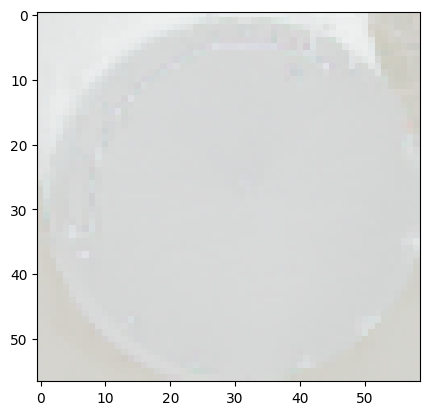

In [17]:
import matplotlib.pyplot as plt
raster = da.data
plt.imshow(np.transpose(raster, (1,2,0))[ 3370:3427, 5033:5092])#)

In [41]:
transform_point_utm_to_wgs84(utm_proj, utmy[minx], utmy[miny])

(-61.85377270321794, 2.2085209557653687)

In [35]:
transform_point_utm_to_wgs84(utm_proj, utmx[minx], np.flip(utmy, 0)[miny])

(-89.44024613824992, 30.59404743284649)

In [ ]:
#determine the lat/lon
nw_lon, nw_lat = transform_point_utm_to_wgs84(utm_proj, utmx[minx], utmy[miny])
se_lon, se_lat = transform_point_utm_to_wgs84(utm_proj, utmx[maxx], utmy[maxy]) 
return pd.Series({'utm_coords': [utmx[minx], utmy[miny], utmx[maxx], utmy[maxy]],
                  'latlon_coords': [nw_lon, nw_lat, se_lon, se_lat]})

In [13]:

obj_xmin, obj_ymin, obj_xmax, obj_ymax = merged_df_by_tank["utm_coords"][0]
obj_width = obj_xmax - obj_xmin
obj_height = obj_ymax - obj_ymin
diameter = min(obj_width, obj_height) * 1 #meter

[210, 12921, 217, 12928]

In [7]:
minx, miny, maxx, maxy = pixel_coords
#determine the lat/lon
nw_lon, nw_lat = transform_point_utm_to_wgs84(utm_proj, utmx[minx], utmy[miny])
se_lon, se_lat = transform_point_utm_to_wgs84(utm_proj, utmx[maxx], utmy[maxy]) 
return pd.Series({'utm_coords': [utmx[minx], utmy[miny], utmx[maxx], utmy[maxy]],
                  'latlon_coords': [nw_lon, nw_lat, se_lon, se_lat]})

NameError: name 'pixel_coords' is not defined

In [17]:
merged_df_by_tank = merge_predicted_bboxes(predict_df_by_tank, dist_limit = 5)

In [19]:
utm, latlon = merged_df_by_tank["bbox_pixel_coords"].apply(lambda box: get_crs_coords(box, utmx, utmy, utm_proj))

In [22]:
minx, miny, maxx, maxy = merged_df_by_tank["bbox_pixel_coords"][0]
minx, miny, maxx, maxy

(9007, 9274, 17967, 18234)

In [20]:
    #determine the lat/lon
    nw_lon, nw_lat = transform_point_utm_to_wgs84(utm_proj, utmx[minx], utmy[miny])
    se_lon, se_lat = transform_point_utm_to_wgs84(utm_proj, utmx[maxx], utmy[maxy]) 
    return pd.Series({'utm_coords': [utmx[minx], utmy[miny], utmx[maxx], utmy[maxy]],
                      'latlon_coords': [nw_lon, nw_lat, se_lon, se_lat]})

'utm_coords'

In [ ]:
predict_df.to_csv(os.path.join(args.prediction_dir, f"predictions_{args.chunk_id}.csv"))
merged_df.to_csv(os.path.join(args.prediction_dir, f"merged_predictions_{args.chunk_id}.csv"))

In [30]:

    #intialize dataframes
    predict_df = pd.DataFrame({})
    merged_df = pd.DataFrame({})
    
    # obtain predictions over the dataframe
    for tile_name in tile_names:
        print(tile_name)
        start_time = time.time()
        img_paths = glob(os.path.join(args.img_dir,"*"+tile_name+"*")) #identify the imgs correspondig to a given tile
        tile_path = os.path.join(args.tile_dir, tile_name +".tif") # specify the tile path
        #obtain tile information
        utmx, utmy, utm_proj, tile_band, tile_height, tile_width = tile_dimensions_and_utm_coords(tile_path) #used
        #predict on images
        predict_df_by_tank = predict_process(img_paths, tile_height, tile_width, model, args)
        #merge neighboring images
        merged_df_by_tank = merge_predicted_bboxes(predict_df_by_tank, dist_limit = 5)
        # calculate utm and lat lon coords
        merged_df_by_tank[["utm_coords","latlon_coords"]] = merged_df_by_tank["bbox_pixel_coords"].apply(\
                                                            lambda box: get_crs_coords(box, utmx, utmy, utm_proj))
        merged_df_by_tank["diameter"] = merged_df_by_tank["utm_coords"].apply(lambda utm_coord: calculate_diameter(utm_coord, resolution = 1))
        #specify the projection used 
        merged_df_by_tank["utm_proj"] = [utm_proj] * len(merged_df_by_tank)
      #update dataframes
        predict_df = pd.concat([predict_df, predict_df_by_tank], ignore_index=True)
        merged_df = pd.concat([merged_df, merged_df_by_tank], ignore_index=True)
        #delete temp dataframe to conserve memory
        del predict_df_by_tank, merged_df_by_tank
        end_time = time.time()
        execution_time = end_time - start_time
        print("Execution time:", execution_time, "seconds")        
        
    predict_df.to_csv(os.path.join(args.prediction_dir, f"predictions_{args.chunk_id}.csv"))
    merged_df.to_csv(os.path.join(args.prediction_dir, f"merged_predictions_{args.chunk_id}.csv"))

2688.0

In [12]:
merged_predictions_0 = pd.read_csv("/work/csr33/images_for_predictions/predictions/merged_predictions_0.csv")
merged_predictions_0["utm_coords"] = merged_predictions_0["utm_coords"].apply(lambda utm_coord: ast.literal_eval(utm_coord))

In [18]:
type(merged_predictions_0["utm_coords"][0])
import ast

s = '[268663.05, 3388092.4499999997, 271351.05, 3385404.4499999997]'
list_values = ast.literal_eval(s)
print(list_values)

str

In [13]:
merged_predictions_0["utm_coords"].apply(lambda utm_coord: calculate_diameter(utm_coord, resolution = 1))


ValueError: too many values to unpack (expected 4)

In [2]:
cv2.imread("'/work/csr33/images_for_predictions/naip_imgs/m_3008325_se_17_060_20191113_20200114_19_10.jpg")

[ WARN:0@4.258] global loadsave.cpp:248 findDecoder imread_(''/work/csr33/images_for_predictions/naip_imgs/m_3008325_se_17_060_20191113_20200114_19_10.jpg'): can't open/read file: check file path/integrity


In [2]:
tile_dir ="/work/csr33/images_for_predictions/naip_tiles"
tile_paths = glob(tile_dir + "/*")  # get a list of all of the tiles in tiles directory
tile_paths.index('/work/csr33/images_for_predictions/naip_tiles/m_3008831_nw_16_030_20211119.tif')

2458

In [5]:
tile_paths.index('/work/csr33/images_for_predictions/naip_tiles/m_3009146_nw_15_030_20211114.tif')

2193

In [ ]:
    
git remote add origin https://github.com/celinerobi/ast_object_detection



In [3]:
list_of_files = glob('/work/csr33/images_for_predictions/naip_imgs'+'/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)


KeyboardInterrupt



In [ ]:
find '/work/csr33/images_for_predictions/naip_imgs' -type f -exec ls -t1 {} + | head -1

In [3]:
naip_df = gpd.read_parquet("/work/csr33/images_for_predictions/naip_tile_in_slosh_modeled_area.parquet")

In [5]:
chunked_naip_data_dir="/work/csr33/images_for_predictions/chunked_naip_data"
chunked_naip_data_filename="chunked_naip_data"

In [6]:
# Calculate the number of rows per chunk
rows_per_chunk = len(naip_df) // 100
df_chunks = [naip_df.iloc[i : i + rows_per_chunk] for i in range(0, len(naip_df), rows_per_chunk)]
for i, chunk in enumerate(df_chunks):
    file_path = f'{chunked_naip_data_dir}/{chunked_naip_data_filename}_{i}.parquet'
    chunk.to_parquet(file_path, index=False)

In [27]:
chip_tiles_concurrent(tile_dir, img_dir, item_dim=640, connections=6)

<class 'AttributeError'>


In [40]:
def get_args_parse():
    parser = argparse.ArgumentParser("")
    parser.add_argument("--chunked_naip_data_dir", default="/work/csr33/images_for_predictions/chunked_naip_data", type=str)
    parser.add_argument("--chunked_naip_data_filename", default="chunked_naip_data", type=str)
    parser.add_argument("--chunk_id",  type=int)

    
    parser.add_argument("--backoff_factor", default=0.5, type=float)
    parser.add_argument("--max_retries", default=5, type=int)
    
    parser.add_argument("--processing_naip_dir", default="/work/csr33/images_for_predictions/processed_naip_data", type=str)
    parser.add_argument("--processing_naip_filename", default="processed_naip_data", type=str)
    parser.add_argument("--imgsz", default=640, type=int)

    args = parser.parse_args()
    return args
import sys
sys.argv = ['my_notebook']
args = get_args_parse()

In [53]:
#os.chdir("/work/csr33/object_detection")
#make sure processing naip dir exist

os.makedirs(args.processing_naip_dir, exist_ok=True)
naip_df = gpd.read_parquet("/work/csr33/images_for_predictions/chunked_naip_data/chunked_naip_data_96.parquet")
args.chunk_id = 96
naip_df["img_url"] = naip_df.assets.apply(lambda asset: asset["image"]["href"])#
data_processing_over_chunk(naip_df, args)

0 Execution time: 101.11169767379761 seconds
1 Execution time: 125.7008740901947 seconds
2 Execution time: 126.36712956428528 seconds
3 Execution time: 136.74841904640198 seconds
4 Execution time: 147.03376173973083 seconds
5 Execution time: 134.94598197937012 seconds
6 Execution time: 149.9262683391571 seconds
7 Execution time: 145.56880497932434 seconds



KeyboardInterrupt



In [2]:
naip_data_path="/work/csr33/images_for_predictions/naip_tile_in_slosh_modeled_area.parquet"

    #os.chdir("/work/csr33/object_detection")
    #make sure processing naip dir exist
import geopandas as gpd  
subset_naip_in_slosh = gpd.read_parquet(naip_data_path)

In [3]:
len(subset_naip_in_slosh)

14012

In [2]:
s = rasterio.open("https://naipeuwest.blob.core.windows.net/naip/v002/al/2021/al_030cm_2021/30087/m_3008709_ne_16_030_20211112.tif")
d = s.read()

<open DatasetReader name='https://naipeuwest.blob.core.windows.net/naip/v002/al/2021/al_030cm_2021/30087/m_3008709_ne_16_030_20211112.tif' mode='r'>